In [ ]:
# !pip install pgmpy

     |████████████████████████████████| 1.9 MB 16.2 MB/s 
     |████████████████████████████████| 1.9 MB 23.6 MB/s 
     |████████████████████████████████| 9.8 MB 23.0 MB/s 
     |████████████████████████████████| 233 kB 13.2 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [24]:
import pandas as pd
from pgmpy.estimators import PC, HillClimbSearch
import networkx as nx
from pgmpy.estimators import BicScore , MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.models import BayesianNetwork
import numpy as np


In [19]:
df = pd.read_csv("data/processed.csv")
print(df.shape)
df.head()

(9709, 13)


,Gender,Own_car,Own_property,Unemployed,Num_children,Num_family,Account_length,Total_income,Age,Income_type,Education_type,Family_status,Target
0,1,1,1,0,0,2,1y-2y,high,30-39,Working,Higher education,Civil marriage,1
1,1,1,1,0,0,2,2y-3y,low,50-59,Working,Secondary / secondary special,Married,0
2,0,0,1,0,0,1,<1y,high,50-59,Commercial associate,Secondary / secondary special,Single / not married,0
3,0,0,1,1,0,1,1y-2y,high,60>=,Pensioner,Higher education,Separated,0
4,1,1,1,0,0,2,<1y,high,40-49,Working,Higher education,Married,0


Working for n conditional variables: 6: 100%|██████████| 6/6 [01:48<00:00, 18.13s/it]


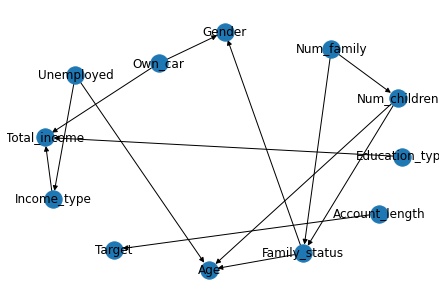

In [ ]:
# PC trial
pcest = PC(df)
pcmodel = pcest.estimate(max_cond_vars=6, significance_level=0.02)
nx.draw(pcmodel, with_labels=True)

  0%|          | 17/1000000 [00:11<186:58:46,  1.49it/s]
-94872.98217930824


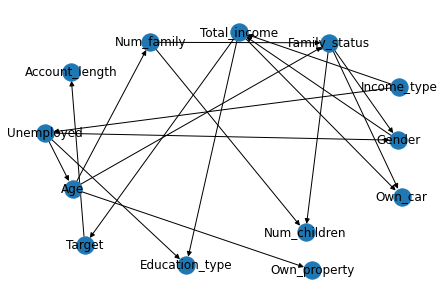

In [11]:
# first naive trial
hillclimbest = HillClimbSearch(df)
bic_score = BicScore(df)
hillclimbmodel = hillclimbest.estimate(scoring_method=bic_score, fixed_edges=[("Total_income", "Target"), ("Income_type", "Total_income")], black_list=[("Own_car","Gender"), ("Gender", "Own_car")])
nx.draw(hillclimbmodel, with_labels=True) 
print(bic_score.score(hillclimbmodel))

In [3]:
print(df.columns)

Index(['Gender', 'Own_car', 'Own_property', 'Unemployed', 'Num_children',
       'Num_family', 'Account_length', 'Total_income', 'Age', 'Income_type',
       'Education_type', 'Family_status', 'Target'],
      dtype='object')


In [7]:

print(np.unique(df["Family_status"]))
print(np.unique(df["Income_type"]))

['Civil marriage' 'Married' 'Separated' 'Single / not married' 'Widow']
['Commercial associate' 'Pensioner' 'State servant' 'Student' 'Working']


Synthax: attr_string: child_string 

'Gender':

'Own_car': 
 
'Own_property':
  
'Unemployed': 
   
'Num_children':

'Num_family': 'Num_children'
       
'Account_length':

'Total_income': Own_property, Own_car, 'Target'
 
'Age': 'Total_income', 'Income_type', 'Account_length'
 
'Income_type': 'Total_income', 'Unemployed'

'Education_type': 'Unemployed', 'Income_type'

'Family_status': 'Num_family'

'Target':

  0%|          | 9/1000000 [00:00<19:37:43, 14.15it/s]
-95142.36127689574


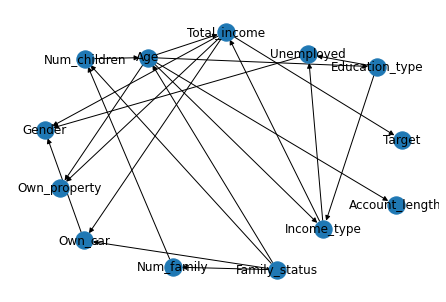

In [16]:
hillclimbmodel_improved = hillclimbest.estimate(scoring_method=bic_score, fixed_edges=[
    ("Total_income", "Target"), 
    ("Income_type", "Total_income"),
    ("Total_income", "Own_property"),
    ("Total_income", "Own_car"),
    ("Income_type", "Unemployed"),
    ("Num_family", "Num_children"),
    ("Age", "Total_income"),
    ("Age", "Income_type"),
    ("Age", "Account_length"),
    ("Income_type", "Total_income"),
    ("Income_type", "Unemployed"),
    ("Education_type", "Unemployed"),
    ("Education_type", "Income_type"),
    ("Family_status", "Num_family")])#, black_list=[("Own_car","Gender"), ("Gender", "Own_car")])
nx.draw(hillclimbmodel_improved, with_labels=True)

print(bic_score.score(hillclimbmodel_improved))

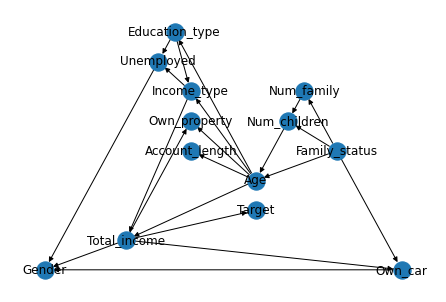

In [39]:
nx.draw_planar(hillclimbmodel_improved, with_labels=True)

In [23]:
bnet = BayesianNetwork(hillclimbmodel_improved.edges())
bnet.fit(df, estimator=MaximumLikelihoodEstimator)
cpds = bnet.get_cpds()

for elem in cpds:
    print(elem)

+---------------+-----+----------------------+
| Family_status | ... | Family_status(Widow) |
+---------------+-----+----------------------+
| Total_income  | ... | Total_income(medium) |
+---------------+-----+----------------------+
| Own_car(0)    | ... | 0.8396946564885496   |
+---------------+-----+----------------------+
| Own_car(1)    | ... | 0.16030534351145037  |
+---------------+-----+----------------------+
+--------------+-----+----------------------+
| Own_car      | ... | Own_car(1)           |
+--------------+-----+----------------------+
| Total_income | ... | Total_income(medium) |
+--------------+-----+----------------------+
| Unemployed   | ... | Unemployed(1)        |
+--------------+-----+----------------------+
| Gender(0)    | ... | 0.5619834710743802   |
+--------------+-----+----------------------+
| Gender(1)    | ... | 0.4380165289256198   |
+--------------+-----+----------------------+
+----------------+-----+
| Education_type | ... |
+----------------+---

In [27]:
bnet = BayesianNetwork(hillclimbmodel_improved.edges())
bnet.fit(df, estimator=BayesianEstimator)
cpds = bnet.get_cpds()

for elem in cpds:
    print(elem)

+---------------+-----+----------------------+
| Family_status | ... | Family_status(Widow) |
+---------------+-----+----------------------+
| Total_income  | ... | Total_income(medium) |
+---------------+-----+----------------------+
| Own_car(0)    | ... | 0.8388324873096447   |
+---------------+-----+----------------------+
| Own_car(1)    | ... | 0.1611675126903553   |
+---------------+-----+----------------------+
+--------------+--------------------+-----+----------------------+
| Own_car      | Own_car(0)         | ... | Own_car(1)           |
+--------------+--------------------+-----+----------------------+
| Total_income | Total_income(high) | ... | Total_income(medium) |
+--------------+--------------------+-----+----------------------+
| Unemployed   | Unemployed(0)      | ... | Unemployed(1)        |
+--------------+--------------------+-----+----------------------+
| Gender(0)    | 0.6652535139133898 | ... | 0.561770761839396    |
+--------------+--------------------+----

In [42]:
print(cpds[0].variables)
print(cpds[0].values)

['Own_car', 'Family_status', 'Total_income']
[[[0.54411765 0.82381616 0.67815483]
  [0.44542665 0.72103402 0.60174717]
  [0.62708018 0.87224265 0.75673077]
  [0.61887173 0.82858415 0.748297  ]
  [0.83088235 0.91482966 0.83883249]]

 [[0.45588235 0.17618384 0.32184517]
  [0.55457335 0.27896598 0.39825283]
  [0.37291982 0.12775735 0.24326923]
  [0.38112827 0.17141585 0.251703  ]
  [0.16911765 0.08517034 0.16116751]]]


In [76]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(bnet)
print(infer.query(['Num_family'], evidence={'Target':1}))

Eliminating: Total_income: 100%|██████████| 6/6 [00:00<00:00, 114.63it/s]+----------------+-------------------+
| Num_family     |   phi(Num_family) |
+================+===================+
| Num_family(1)  |            0.2003 |
+----------------+-------------------+
| Num_family(2)  |            0.5334 |
+----------------+-------------------+
| Num_family(3)  |            0.1688 |
+----------------+-------------------+
| Num_family(4+) |            0.0975 |
+----------------+-------------------+



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=03282642-4d6b-431b-a45f-9f21a6236fff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>